In [1]:
import random
import math
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

<h1>Logistic Regression From Scratch</h1>

<h3>Helper Functions</h3>

In [2]:
def euclidean_distance(point1, point2):
    distance = 0
    for i in range(len(point1)):
        distance += (point1[i] - point2[i]) ** 2
    return distance ** 0.5

def knn_predict(test_point, data, labels, k):
    distances = []
    for i in range(len(data)):
        distances.append((euclidean_distance(test_point, data[i]), labels[i]))
    
    distances.sort()
    
    neighbors = distances[:k]
    
    votes = [0, 0]
    for distance, label in neighbors:
        votes[label] += 1
    
    return 1 if votes[1] > votes[0] else 0

def calculate_accuracy(test_data, test_labels, train_data, train_labels, k):
    correct_predictions = 0

    for i in range(len(test_data)):
        predicted_label = knn_predict(test_data[i], train_data, train_labels, k)
        if predicted_label == test_labels[i]:
            correct_predictions += 1

    accuracy = correct_predictions / len(test_data)
    return accuracy

def calculate_performance(test_data, test_labels, train_data, train_labels, k):
    predictions = [knn_predict(point, train_data, train_labels, k) for point in test_data]
    tn, fp, fn, tp = confusion_matrix(test_labels, predictions).ravel()

    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    auc = roc_auc_score(test_labels, predictions)

    return {
        "accuracy": (tp + tn) / (tp + tn + fp + fn),
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "auc": auc
    }

def evaluate_metrics(true_labels, predictions):
    tn, fp, fn, tp = confusion_matrix(true_labels, predictions).ravel()
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score
    }


def bias_variance_analysis(train_data, train_labels, test_data, test_labels, k_values):
    results = []

    for k in k_values:
        train_predictions = [knn_predict(point, train_data, train_labels, k) for point in train_data]
        test_predictions = [knn_predict(point, train_data, train_labels, k) for point in test_data]

        train_metrics = evaluate_metrics(train_labels, train_predictions)
        test_metrics = evaluate_metrics(test_labels, test_predictions)

        results.append({
            "k": k,
            "train_performance": train_metrics,
            "test_performance": test_metrics
        })

    return results


def perform_kfold_cross_validation(data, labels, k, n_splits=10):
    kf = KFold(n_splits=n_splits)
    performances = []

    for train_index, test_index in kf.split(data):
        trainingData, testingData = [data[i] for i in train_index], [data[i] for i in test_index]
        trainingLabels, testingLabels = [labels[i] for i in train_index], [labels[i] for i in test_index]

        performance = calculate_performance(testingData, testingLabels, trainingData, trainingLabels, k)
        performances.append(performance)

    return {
        metric: sum([perf[metric] for perf in performances]) / n_splits
        for metric in performances[0]
    }

<h3>Read in the Data</h3>

In [4]:
def load_data(file_path):
    data = []
    labels = []

    with open(file_path, 'r') as file:
        for line in file:
            tokens = line.strip().split()

            binary_feature = 1 if tokens[4] == "Present" else 0
            
            tokens[4] = binary_feature

            features = [float(token) for token in tokens[:-1]]

            label = int(tokens[-1])

            data.append(features)
            labels.append(label)

    return data, labels


dataset1 = '../../dataset/project3_dataset1.txt'
dataset2 = '../../dataset/project3_dataset2.txt'

data1, labels1 = load_data(dataset1)
data2, labels2 = load_data(dataset2)

# Splitting Data
training_testing_boundary = .7
data1Split = int(len(data1) * training_testing_boundary)
data2Split = int(len(data2) * training_testing_boundary)


trainingData1 = data1[:data1Split]
trainingData2 = data2[:data2Split]
trainingLabels1 = labels1[:data1Split]
trainingLabels2 = labels2[:data2Split]

testingData1 = data1[data1Split:]
testingData2 = data2[data2Split:]
testingLabels1 = labels1[data1Split:]
testingLabels2 = labels2[data2Split:]





<h3>Model Testing</h3>

k = 1
Training Performance: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
Testing Performance: {'accuracy': 0.9122807017543859, 'precision': 0.8840579710144928, 'recall': 0.8970588235294118, 'f1_score': 0.8905109489051095}
k = 3
Training Performance: {'accuracy': 0.9547738693467337, 'precision': 0.9565217391304348, 'recall': 0.9166666666666666, 'f1_score': 0.9361702127659574}
Testing Performance: {'accuracy': 0.9181286549707602, 'precision': 0.8970588235294118, 'recall': 0.8970588235294118, 'f1_score': 0.8970588235294118}
k = 5
Training Performance: {'accuracy': 0.9422110552763819, 'precision': 0.9618320610687023, 'recall': 0.875, 'f1_score': 0.9163636363636364}
Testing Performance: {'accuracy': 0.935672514619883, 'precision': 0.9253731343283582, 'recall': 0.9117647058823529, 'f1_score': 0.9185185185185185}
k = 10
Training Performance: {'accuracy': 0.9422110552763819, 'precision': 0.9689922480620154, 'recall': 0.8680555555555556, 'f1_score': 0.9157509157509157}
Te

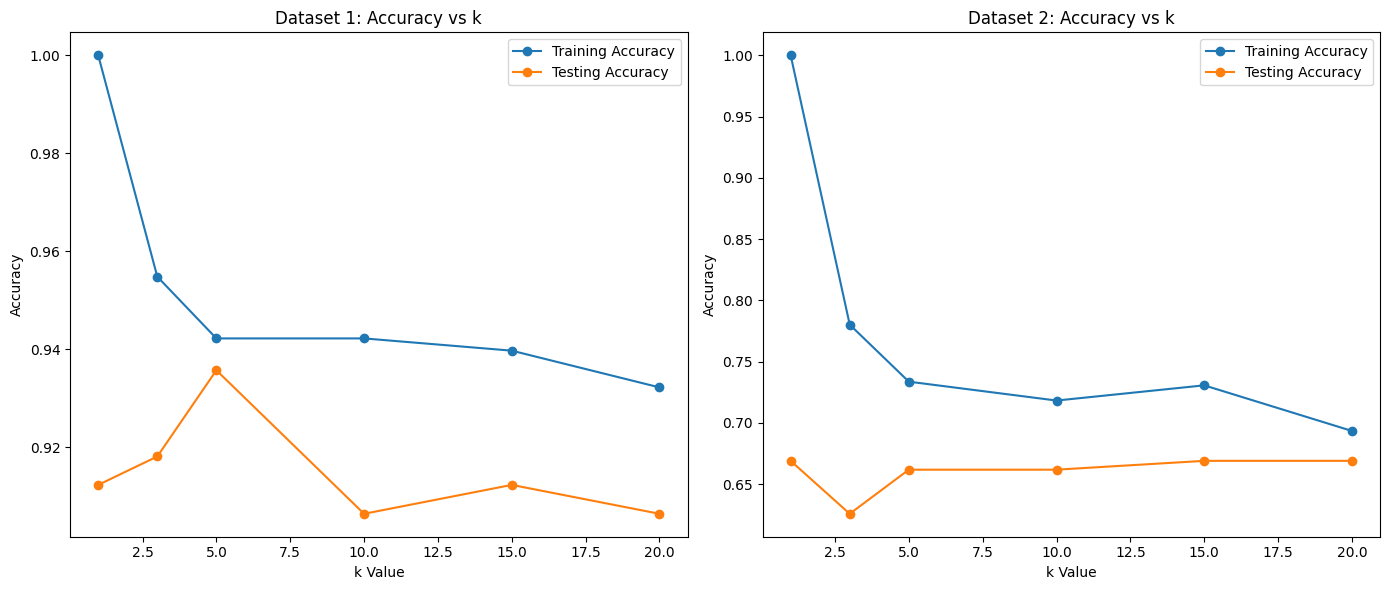

In [5]:
k_values = [1, 3, 5, 10, 15, 20]
analysis1_results = bias_variance_analysis(trainingData1, trainingLabels1, testingData1, testingLabels1, k_values)
analysis2_results = bias_variance_analysis(trainingData2, trainingLabels2, testingData2, testingLabels2, k_values)

for result in analysis1_results:
    print(f"k = {result['k']}")
    print("Training Performance:", result['train_performance'])
    print("Testing Performance:", result['test_performance'])



for result in analysis2_results:
    print(f"k = {result['k']}")
    print("Training Performance:", result['train_performance'])
    print("Testing Performance:", result['test_performance'])


# Training and Testing Accuracies for the first dataset
training_accuracy_1 = [1.0, 0.9548, 0.9422, 0.9422, 0.9397, 0.9322]
testing_accuracy_1 = [0.9123, 0.9181, 0.9357, 0.9064, 0.9123, 0.9064]

# Training and Testing Accuracies for the second dataset
training_accuracy_2 = [1.0, 0.7802, 0.7337, 0.7183, 0.7307, 0.6935]
testing_accuracy_2 = [0.6691, 0.6259, 0.6619, 0.6619, 0.6691, 0.6691]

# Create plots
plt.figure(figsize=(14, 6))

# Plot for the first dataset
plt.subplot(1, 2, 1)
plt.plot(k_values, training_accuracy_1, label='Training Accuracy', marker='o')
plt.plot(k_values, testing_accuracy_1, label='Testing Accuracy', marker='o')
plt.title('Dataset 1: Accuracy vs k')
plt.xlabel('k Value')
plt.ylabel('Accuracy')
plt.legend()

# Plot for the second dataset
plt.subplot(1, 2, 2)
plt.plot(k_values, training_accuracy_2, label='Training Accuracy', marker='o')
plt.plot(k_values, testing_accuracy_2, label='Testing Accuracy', marker='o')
plt.title('Dataset 2: Accuracy vs k')
plt.xlabel('k Value')
plt.ylabel('Accuracy')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()